# This is the Colab Notebook for Summarization using PEGASUS on our generated dataset

In [ ]:
!pip3 install transformers

In [ ]:
!pip3 install sentencepiece

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModelForSeq2SeqLM

In [ ]:
model_name = 'google/pegasus-large'

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
ARTICLE= """Picture this: a herd of elephants flies past you at sixty miles per hour, followed by a streak of tigers, a pride of lions, and a bunch of clowns. 
What do you see? It must be a circus train! One of the first uses of the circus train is credited to W.C. Coup. He 
partnered with P.T. Barnum in 1871 to expand the reach of their newly combined shows using 
locomotives. Before circus trains, these operators had to lug around all of their animals, 
performers, and equipment with a team of more than 600 horses. Since there were no highways, 
these voyages were rough and took a long time. Circuses would stop at many small towns 
between the large venues. Performing at many of these small towns was not very profitable. 
Because of these limitations, circuses could not grow as large as the imaginations of the 
operators. After they began using circus trains, Barnum and Coup only brought their show to 
large cities. These performances were much more profitable and the profits went toward creating 
an even bigger and better circus. Multiple rings were added and the show went on. Today, 
Ringling Bros. and Barnum and Bailey Circus still rely on the circus train to transport their 
astounding show, but now they use two."""
inputs = tokenizer.encode("summarize: " + ARTICLE, return_tensors="pt", truncation=True, max_length=512)
outputs = model.generate(inputs, max_length=150, min_length=40, num_beams=4, length_penalty=2.0, early_stopping=True)
print("Your summary: ")
print(tokenizer.decode(outputs[0]))

Your summary: 
<pad> used the circus train to transport their show to large cities. made their show bigger and better. still use the circus train to transport their show to large cities. still use the circus train to transport their show to large cities.</s>


In [ ]:
!pip install ohmeow-blurr -q
!pip install datasets -q

In [ ]:
!pip install bert-score -q

In [ ]:
import datasets
import pandas as pd
import seaborn as sns
from fastai.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#showing an example of dataset
df = pd.read_csv('trainDataPoints.csv')
df.head(5)
df1 = df.iloc[0:10000]

In [ ]:
#getting the required objects (the architecture, tokenizer, config, and model, using get_hf_objects helper method
pretrained_model_name = "google/pegasus-large"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=PegasusForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('pegasus',
 transformers.models.pegasus.configuration_pegasus.PegasusConfig,
 transformers.models.pegasus.tokenization_pegasus_fast.PegasusTokenizerFast,
 transformers.models.pegasus.modeling_pegasus.PegasusForConditionalGeneration)

In [ ]:
#parameters dict generation with the default values 
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization')
text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 0,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': False,
 'encoder_no_repeat_ngram_size': 0,
 'eos_token_id': 1,
 'length_penalty': 0.8,
 'max_length': 256,
 'min_length': 0,
 'no_repeat_ngram_size': 0,
 'num_beam_groups': 1,
 'num_beams': 8,
 'num_return_sequences': 1,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'pad_token_id': 0,
 'repetition_penalty': 1.0,
 'return_dict_in_generate': False,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

In [ ]:
#customizing the text generation by changing values in text_gen_kwargs
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                              max_length=256, max_tgt_length=128, text_gen_kwargs= text_gen_kwargs)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)
#change article to document and change highlights to sumamry
dblock = DataBlock(blocks=blocks, get_x=ColReader('data'), get_y=ColReader('target'), splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(df1, bs=2)

In [ ]:
#batch shape
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 79]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,Rank:1.0;_4th_Runner_up:5.0;Country:USA;tot:56.0;Semifinalists:28.0;Miss_Universe:8;_2nd_Runner_up:6.0;_1st_Runner_up:8.0;_3rd_Runner_up:1.0;;Rank:2.0;_4th_Runner_up:2.0;Country:Venezuela;tot:38.0;Semifinalists:14.0;Miss_Universe:6;_2nd_Runner_up:6.0;_1st_Runner_up:6.0;_3rd_Runner_up:4.0;;Rank:3.0;_4th_Runner_up:3.0;Country:Puerto Rico;tot:19.0;Semifinalists:7.0;Miss_Universe:5;_2nd_Runner_up:2.0;_1st_Runner_up:1.0;_3rd_Runner_up:1.0;;Rank:4.0;_4th_Runner_up:4.0;Country:Sweden;tot:29.0;Semifinalists:16.0;Miss_Universe:3;_2nd_Runner_up:2.0;_1st_Runner_up:1.0;_3rd_Runner_up:3.0;;,Table Miss Universe country rankings has 101 rows and Column Rank has entries with 81.0 as maximum value 51.0 as median and 1.0 as minimum value and Column 4th Runner up has entries with unique values ranging between 5.0 and 0.0 and Column Country has entries with uniques value between USA and Vietnam
1,"Year:2012.0;Trainer:Gary Simms;Winner:Blueeyesintherein;Owner:Self/King/Morgenson/Travis, et al;Time:1:11.71;Jockey:Leandro Goncalves;;Year:2011.0;Trainer:Gary Simms;Winner:Flashy Lassie;Owner:Barry L. King;Time:1:10.89;Jockey:Kent Desormeaux;;Year:2010.0;Trainer:Dale Romans;Winner:Just Louise;Owner:Eldon Farm Equine;Time:1:11.85;Jockey:Robby Albarado;;Year:2009.0;Trainer:D. Wayne Lukas;Winner:Decelerator;Owner:Westrock Stables;Time:1:11.28;Jockey:Julien Leparoux;;Year:2008.0;Trainer:Todd A. Pletcher;Winner:Garden District;Owner:Twin Creeks Racing Stable;Time:1:11.07;Jockey:Robby Albarado;;Year:2007.0;Trainer:Steve Asmussen;Winner:Rated Fiesty;Owner:Heiligbrodt Racing et al.;Time:1:09.27;Jockey:Shaun Bridg",Table Churchill Downs Debutante Stakes has 18 rows and Column Year has entries with unique values ranging between 2012.0 and 1995.0 and Column Trainer has entries with uniques value between Gary Simms and D. Wayne Lukas and Column Winner has entries with uniques value between Blueeyesintherein and Golden Attraction


In [ ]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
       
        }
    }

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() 
learn.freeze()

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0831763744354248)

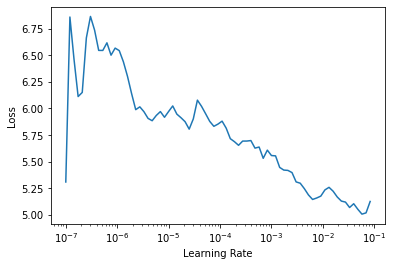

In [ ]:
learn.lr_find(suggestions=True)

In [ ]:
#running a batch to the model and output the shape
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(4,
 tensor(5.8737, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([2, 66, 96103]))

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-3, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,2.005469,1.625858,0.781470,0.649403,0.731209,07:20
1,nan,1.230363,0.786678,0.662255,0.746346,07:05
2,nan,1.125182,0.841110,0.731465,0.795678,06:07
3,nan,1.062772,0.851803,0.740784,0.808199,06:29
4,nan,1.033826,0.841756,0.730302,0.802612,06:43
5,nan,1.002506,0.848218,0.741662,0.810927,06:27
6,nan,1.005894,0.865210,0.752314,0.819777,06:22
7,nan,1.007051,0.864515,0.760244,0.824424,06:19
8,nan,1.043588,0.868369,0.767242,0.827664,06:19
9,nan,1.060543,0.865729,0.761711,0.824111,06:21


In [ ]:
learn.show_results(learner=learn, max_n=2)

,text,target,prediction
0,Representative:John J. Eagan;Party:Democratic;Lifespan:1872–1956;Years:1913–1921 1923–1925;State:New Jersey;;Representative:Samuel W. Eager;Party:National Republican;Lifespan:1789–1860;Years:1830–1831;State:New York;;Representative:Joe H. Eagle;Party:Democratic;Lifespan:1870–1963;Years:1913–1921 1933–1937;State:Texas;;Representative:Benjamin T. Eames;Party:Republican;Lifespan:1818–1901;Years:1871–1879;State:Rhode Island;;Representative:Daniel S. Earhart;Party:Democratic;Lifespan:1907–1976;Years:1936–1937;State:Ohio;;Representative:Elias Earle;Party:Democratic-Republican;Lifespan:1762–1823;Years:1805–1807 1811–1815 1817–1821;State:South Carolina;;Representative:John B. Earle;Party:Democratic-Republican;Lifespan:1766–1836;Years:1803–1805;State:South Carolina;;Representative:Samuel Earle;Party:Democratic-Republican;Lifespan:1760–1833;Years:1795–1797;State:South Carolina;,Table List of former members of the United States House of Representatives E has 249 rows and Column Representative has entries with uniques value between John J. Eagan and Thomas W. Ewing and Column Party has entries with uniques value between Democratic and Republican and Column Lifespan has entries with uniques value between 1872–1956 and 1935–,Table History of the United States Congress has 13 rows and Column Representative has entries with uniques value between John J. Eagan and John B. Earle and Column Party has entries with 100.0 percent probability of Democratic and Column Lifespan has entries with uniques value between 1867–1921 and 1817–1821
1,County:Rutland UA;TFR_2006:2.81;Live_births_2006:391.0;GFR_2006:61.7;Whites_as_of_Pop_:98.10%;;County:Blackburn with Darwen UA;TFR_2006:2.49;Live_births_2006:2315.0;GFR_2006:78.3;Whites_as_of_Pop_:77.90%;;County:Slough UA;TFR_2006:2.47;Live_births_2006:2317.0;GFR_2006:85.0;Whites_as_of_Pop_:63.60%;;County:Luton UA;TFR_2006:2.43;Live_births_2006:3325.0;GFR_2006:81.9;Whites_as_of_Pop_:71.90%;;County:Peterborough UA;TFR_2006:2.42;Live_births_2006:2630.0;GFR_2006:78.0;Whites_as_of_Pop_:89.70%;;County:Milton Keynes UA;TFR_2006:2.20;Live_births_2006:3415.0;GFR_2006:7,Table Total fertility rate in England by county unitary authority has 86 rows and Column County has entries with uniques value between Rutland UA and York UA and Column TFR 2006 has entries with uniques value between 2.81 and 1.49 and Column Live births 2006 has entries with 69498.0 as maximum value 3444.0 as median and 391.0 as minimum value,Table List of towns and cities in the United Kingdom has 99 rows and Column County has entries with uniques value between Rutland UA and Berkshire UA and Column TFR 2006 has entries with unique values ranging between 2.81 and 1.03 and Column Live births 2006 has entries with uniques value between 391.0 and 341.0
